<h1>Question 1</h1>
<h2> part a</h2>
<h3>To identify the top eigenvectors necessary to maintain a cumulative variance exceeding 0.9:</h3>
<p>Begin by loading the data and extracting 2500 samples from each class, forming a subdata set with a total of 25,000 samples, as specified.</p>
<p>Flatten the 32x32 RGB images and apply PCA to obtain the corresponding eigenvectors.</p>
<p>Calculate the variance explained by each principal component and incrementally add eigenvectors until the cumulative variance surpasses or equals 0.9, identifying the top components.</p>
<p>Lastly, visualize the relationship between Proportion of Variance and eigenvectors through a plotted graph.</p>

In [98]:
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


train_data = loadmat('./train_32x32.mat')



In [99]:
#data Extration (features)
X_train = train_data['X']
y_train = train_data['y']
classes = len(np.unique(y_train))
# print(classes)

# Create an empty list to store indices for each class
subset_classes = []

# Iterate over each class
for class_label in range(classes):
    # print(class_label)
    # Find indices of samples belonging to the current class
    indices_for_class = np.where(y_train == class_label+1)[0]
    
    # Check if there are enough samples for the current class
    if len(indices_for_class) >= 2500:
        # Randomly select 2500 samples if available
        selected_indices = np.random.choice(indices_for_class, size=2500, replace=False)
        subset_classes.extend(selected_indices)
    else:
        # If there are not enough samples, use all available samples for this class
        subset_classes.extend(indices_for_class)

# Convert the list to a NumPy array
subset_classes = np.array(subset_classes)


# New dataset of size 2500
subset_classes_X_train = X_train[:, :, :, subset_classes ]
subset_classes_Y_train = y_train[subset_classes ]
# Flatten the data for PCA
X_train_2D = subset_classes_X_train.reshape((32*32*3,-1))


# Standardize the data
scaler = StandardScaler()
X_train_standardized = X_train_2D.T


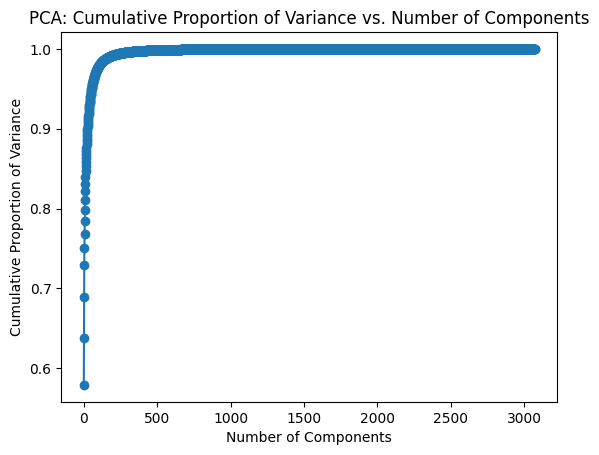

Number of components to keep 90% variance: 26


In [100]:


# Perform PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_standardized)

# Cumulative sum of explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components to keep for 90% variance
num_components_90 = np.argmax(cumulative_variance > 0.9) + 1

# Plot PoV against the number of components
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Proportion of Variance')
plt.title('PCA: Cumulative Proportion of Variance vs. Number of Components')
plt.show()

print(f"Number of components to keep 90% variance: {num_components_90}")

<h2>part b</h2>
<h3>To reconstruct 10 samples from the SVHN dataset (one from each class) using the top 10 eigenvectors:</h3>
<p>We began by choosing 10 samples from each class, flattening the selected samples, and transforming them using all available eigenvectors.</p>
<p>Subsequently, the reconstruction process was carried out utilizing the top 10 eigenvectors.</p>
<p>Ultimately, the original and reconstructed samples were presented for comparison.</p>

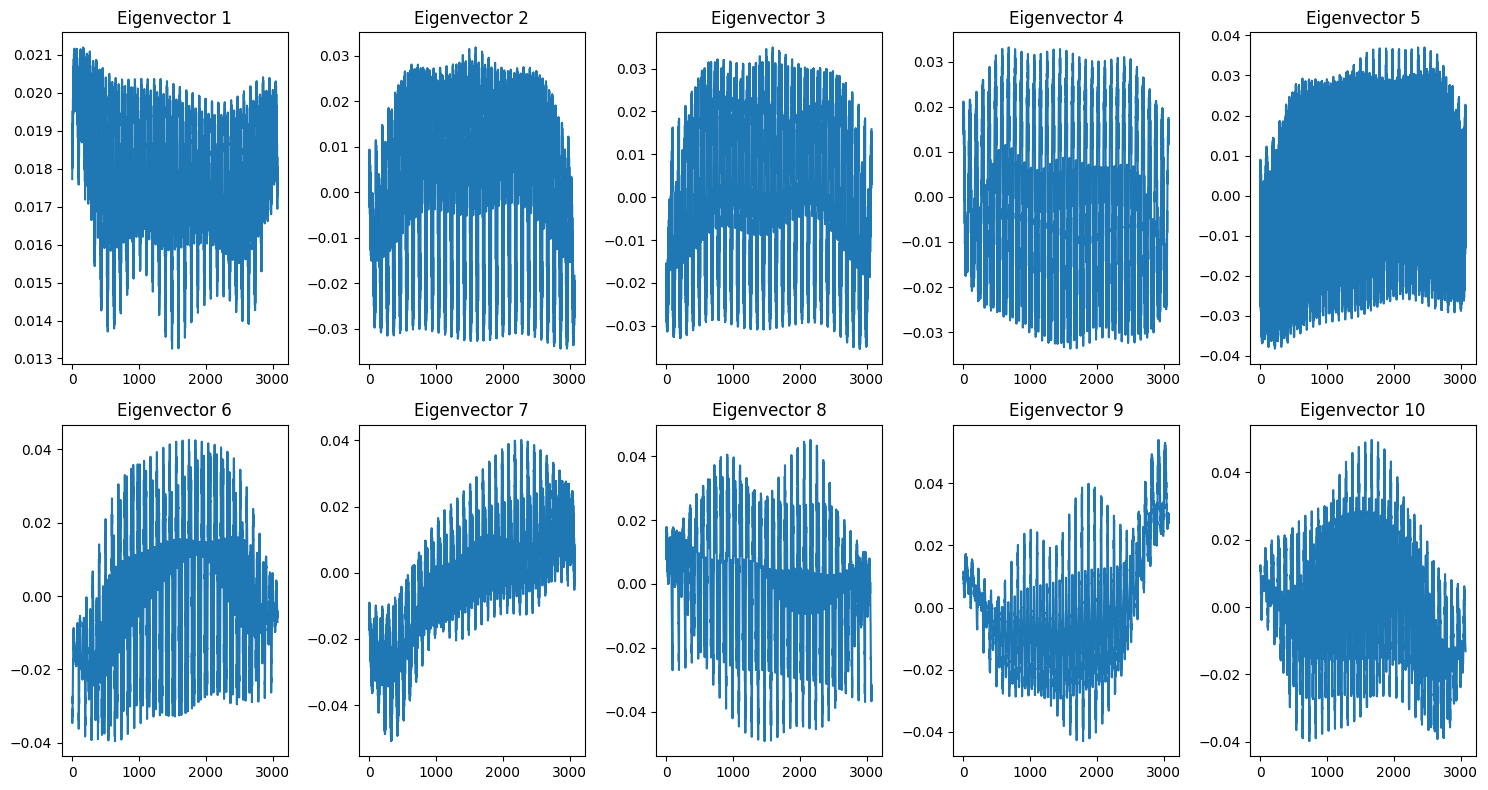

In [101]:
# Assuming top_10_eigenvectors is a 2D array where each row is an eigenvector
top_10_eigenvectors = pca.components_[:10, :]

# Plotting the values along each dimension for the top 10 eigenvectors
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.plot(top_10_eigenvectors[i])
    plt.title(f'Eigenvector {i + 1}')

plt.tight_layout()
plt.show()

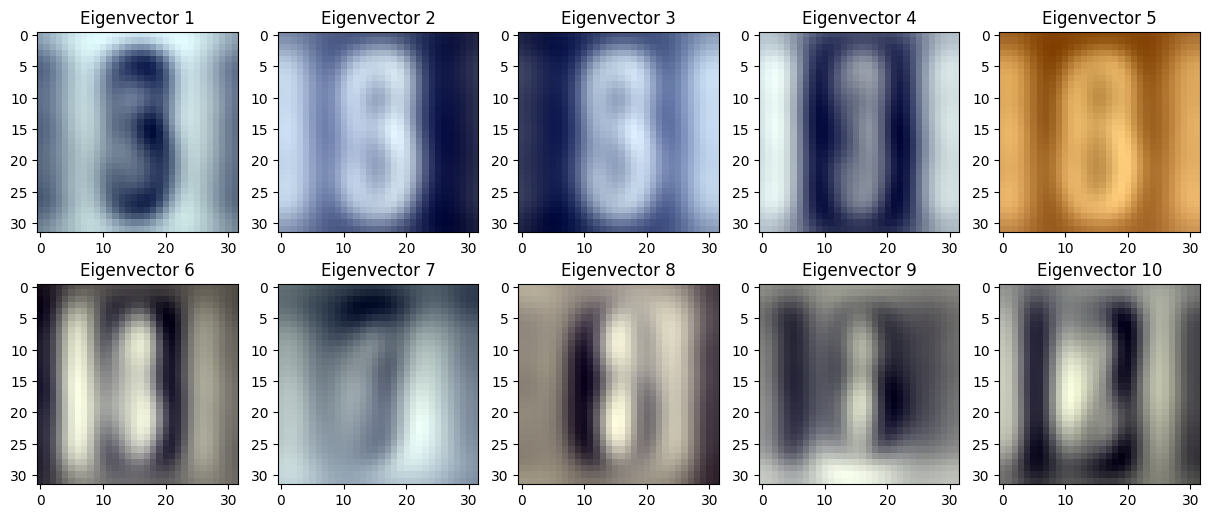

In [102]:


fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    # Reshape eigenvector to image shape
    reshaped_eigenvector = top_10_eigenvectors[i].reshape((32, 32, 3))

    # Convert values to [0, 255] range
    normalized_eigenvector = ((reshaped_eigenvector - reshaped_eigenvector.min()) / 
                              (reshaped_eigenvector.max() - reshaped_eigenvector.min()) * 255)

    # Display the eigenvector as an image
    ax.imshow(normalized_eigenvector.astype(np.uint8), cmap='magma')

    ax.set_title(f'Eigenvector {i + 1}')

plt.show()


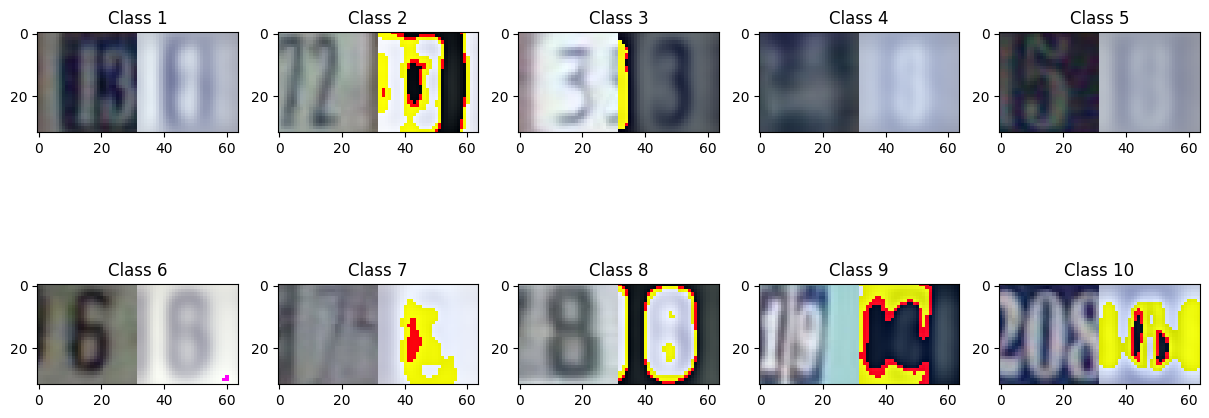

In [103]:
# Use the top 10 eigenvectors for reconstruction
top_10_eigenvectors = pca.components_[:10, :]

# Reconstruct 10 samples (one from each class) using the top 10 eigenvectors
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    # Select one sample from each class
    class_indices = np.where(subset_classes_Y_train == i + 1)[0]
    sample_index = np.random.choice(class_indices, size=1)[0]
    
    # Get the original image
    original_image = subset_classes_X_train[:, :, :, sample_index]
    
    # Flatten the original image for reconstruction
    original_flattened = original_image.reshape((32*32*3, -1)).T
    
    # Project the flattened image onto the top 10 eigenvectors
    projected_image = np.dot(original_flattened, top_10_eigenvectors.T)
    
    # Reconstruct the image using the top 10 eigenvectors
    reconstructed_image = np.dot(projected_image, top_10_eigenvectors) + pca.mean_
    
    # Reshape the reconstructed image to its original shape
    reconstructed_image = reconstructed_image.reshape((32, 32, 3))
    
    # Display the original and reconstructed images side by side
    ax.imshow(np.hstack([original_image.astype(np.uint8), reconstructed_image.astype(np.uint8)]))
    ax.set_title(f"Class {i + 1}")

plt.show()


<h1>Original Image and Reconstructed Image</h1>


<h2>Part c</h2> <p>To commence this segment, the initial step involves loading the test data and transforming the flattened test data using the PCA model established during training.</p>
    <p>Utilizing built-in functions for k-NN classification, we employed the .fit method for training and the .predict method for making predictions on the test data.</p>
    <p>Ultimately, accuracy measurements are obtained for three specified scenarios with k values set to 5 and 7.</p>

In [118]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

test_data = loadmat('./test_32x32.mat')  # Adjust the file path accordingly
X_test = test_data['X']
y_test = test_data['y']

# reshaping the test data
X_test_flatten = X_test.reshape(-1, X_test.shape[-1])

X_test = X_test_flatten.T

#applying PCA on test data

X_test_pca = pca.transform(X_test)


# knn on raw data
#k-NN on raw data k= 5
knn_raw = KNeighborsClassifier(n_neighbors=5)
knn_raw.fit(X_train_standardized, subset_classes_Y_train.ravel())
predictions_raw = knn_raw.predict(X_test)

# Calculate accuracy for raw data 
accuracy_raw = accuracy_score(test_labels.ravel(), predictions_raw)
print(f'Accuracy on raw data k = 5: {accuracy_raw:.4f}')

# knn for data obtained after PCA in part 1(a)
X_train_pca_27 = X_train_pca[:, :num_components_90]
knn_pca_27 = KNeighborsClassifier(n_neighbors=5)
knn_pca_27.fit(X_train_pca_27, subset_classes_Y_train.ravel())
predictions_pca_27 = knn_pca_27.predict(X_test_pca[:, :num_components_90])

# Calculate accuracy for raw data 
accuracy_pca_27 = accuracy_score(test_labels.ravel(), predictions_pca_27)
print(f'Accuracy on  data 1(a) k = 5: {accuracy_pca_27:.4f}')
# knn for data obtained after PCA in part 1(b) 

X_train_pca_10 = X_train_pca[:, :10]
knn_pca_10 = KNeighborsClassifier(n_neighbors=5)
knn_pca_10.fit(X_train_pca_10, subset_classes_Y_train.ravel())
predictions_pca_10 = knn_pca_10.predict(X_test_pca[:,:10])


accuracy_pca_10 = accuracy_score(test_labels.ravel(), predictions_pca_10)
print(f'Accuracy on  data 1(b) k = 5: {accuracy_pca_10:.4f}')

# k = 7
knn_raw = KNeighborsClassifier(n_neighbors=7)
knn_raw.fit(X_train_standardized, subset_classes_Y_train.ravel())
predictions_raw = knn_raw.predict(X_test)

# Calculate accuracy for raw data 
accuracy_raw = accuracy_score(test_labels.ravel(), predictions_raw)
print(f'Accuracy on raw data k = 7: {accuracy_raw:.4f}')

# knn for data obtained after PCA in part 1(a)
X_train_pca_27 = X_train_pca[:, :num_components_90]
knn_pca_27 = KNeighborsClassifier(n_neighbors=7)
knn_pca_27.fit(X_train_pca_27, subset_classes_Y_train.ravel())
predictions_pca_27 = knn_pca_27.predict(X_test_pca[:, :num_components_90])

# Calculate accuracy for raw data 
accuracy_pca_27 = accuracy_score(test_labels.ravel(), predictions_pca_27)
print(f'Accuracy on  data 1(a) k = 7: {accuracy_pca_27:.4f}')
# knn for data obtained after PCA in part 1(b) 

X_train_pca_10 = X_train_pca[:, :10]
knn_pca_10 = KNeighborsClassifier(n_neighbors=7)
knn_pca_10.fit(X_train_pca_10, subset_classes_Y_train.ravel())
predictions_pca_10 = knn_pca_10.predict(X_test_pca[:,:10])

# Calculate accuracy for raw data 

accuracy_pca_10 = accuracy_score(test_labels.ravel(), predictions_pca_10)
print(f'Accuracy on  data 1(b) k = 7: {accuracy_pca_10:.4f}')

Accuracy on raw data k = 5: 0.4064
Accuracy on  data 1(a) k = 5: 0.4038
Accuracy on  data 1(b) k = 5: 0.2579
Accuracy on raw data k = 7: 0.4199
Accuracy on  data 1(a) k = 7: 0.4158
Accuracy on  data 1(b) k = 7: 0.2636


<h2>Observations:</h2>

<ul>
    <li>Increasing the value of k from 5 to 7 results in an improvement in accuracy, attributed to the training on a greater number of neighbors.</li>
    <li>The reduction in dimensions correlates with a decrease in accuracy.</li>
    <li>For the dimensions capturing 90% of the variance as observed in part a, the accuracy remains nearly the same as that of the raw data.</li>
</ul>

<h2>Question 2: Part a</h2>

<ul>
    <li>First, we performed k-means clustering with 10 clusters on both raw data and data obtained after PCA with dimensions as in 1(A) and 1(B).</li>
    <li>Next, we identified the indices of images nearest to cluster centroids for each dataset, visualizing them accordingly.</li>
    <li>Finally, we checked whether clusters contained images belonging to the same class. If not, we printed "mixed class."</li>
</ul>

In [105]:
from sklearn.cluster import KMeans


# Flatten the raw data for k-means clustering

# X_train_raw_flattened = X_train.reshape((32*32*3, -1)).T
# print("X_train_raw_flattened",X_train_raw_flattened.shape)
# Perform k-means clustering on raw data
kmeans_raw = KMeans(n_clusters=10,n_init=10, random_state=42)
kmeans_raw.fit(X_train_standardized)


# Get cluster labels and centroids
labels_raw = kmeans_raw.labels_
centroids_raw = kmeans_raw.cluster_centers_
print(labels_raw.shape)
print(centroids_raw.shape)




(25000,)
(10, 3072)


[12991 16971 21047  4686  9290  1570   141  1239  7843  7108]
X_train_standardized: (25000, 3072)
[12991 16971 21047  4686  9290  1570   141  1239  7843  7108]
(10,)


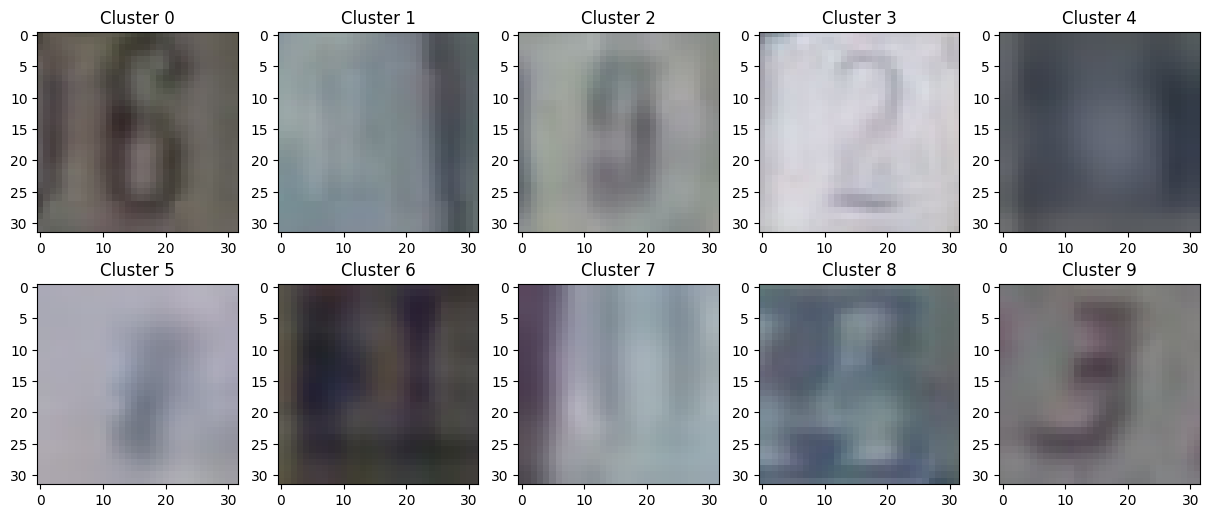

In [106]:

from sklearn.metrics.pairwise import pairwise_distances_argmin_min
closest_image_idx, _  = pairwise_distances_argmin_min(centroids_raw, X_train_standardized)
print(closest_image_idx)
print("X_train_standardized:",X_train_standardized.shape)
print(closest_image_idx)
print(closest_image_idx.shape)
# Visualize the centroids
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    nearest_image = X_train_standardized[closest_image_idx[i]].reshape((32, 32, 3))  # Fix the index
    ax.imshow(nearest_image.astype(np.uint8))
    ax.set_title(f"Cluster {i}")

plt.show()

In [107]:
# Project the raw data onto the top 10 eigenvectors
X_train_pca_projected_10 = X_train_pca[:,:10]
print("X_train_pca_projected_10",X_train_pca_projected_10.shape)
# Perform k-means clustering on PCA data with dimension 10
kmeans_pca_10 = KMeans(n_clusters=10,n_init=10, random_state=42)
kmeans_pca_10.fit(X_train_pca_projected_10)

# Get cluster labels and centroids
labels_pca_10 = kmeans_pca_10.labels_
centroids_pca_10 = kmeans_pca_10.cluster_centers_

# # Visualize the centroids
# fig, axes = plt.subplots(2, 5, figsize=(15, 6))
# for i, ax in enumerate(axes.flat):
#     centroid_image_pca_10 = np.dot(centroids_pca_10[i, :], top_10_eigenvectors) + pca.mean_
#     centroid_image_pca_10 = centroid_image_pca_10.reshape((32, 32, 3))
#     ax.imshow(centroid_image_pca_10.astype(np.uint8))
#     ax.set_title(f"Cluster {i}")

# plt.show()


X_train_pca_projected_10 (25000, 10)


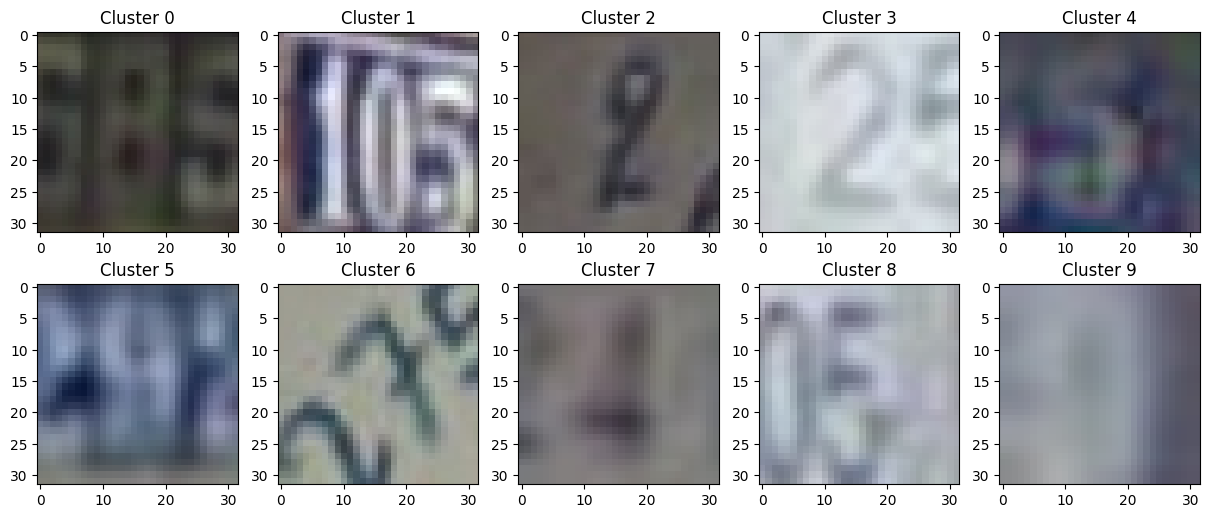

In [108]:


closest_image_idx_10, _  = pairwise_distances_argmin_min(centroids_pca_10,X_train_pca_projected_10)

# Visualize the centroids
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
j=0
for i, ax in enumerate(axes.flat):
    nearest_image = X_train_standardized[closest_image_idx_10[j]].reshape((32, 32, 3))  # Fix the index
    j +=1
    ax.imshow(nearest_image.astype(np.uint8))
    ax.set_title(f"Cluster {i}")
    

plt.show()

In [109]:
X_train_pca_projected_27 = X_train_pca[:,:27]

# Perform k-means clustering on PCA data with dimension 10
kmeans_pca_27 = KMeans(n_clusters=10,n_init=10, random_state=42)
kmeans_pca_27.fit(X_train_pca_projected_27)

# Get cluster labels and centroids
labels_pca_27 = kmeans_pca_27.labels_
centroids_pca_27 = kmeans_pca_27.cluster_centers_

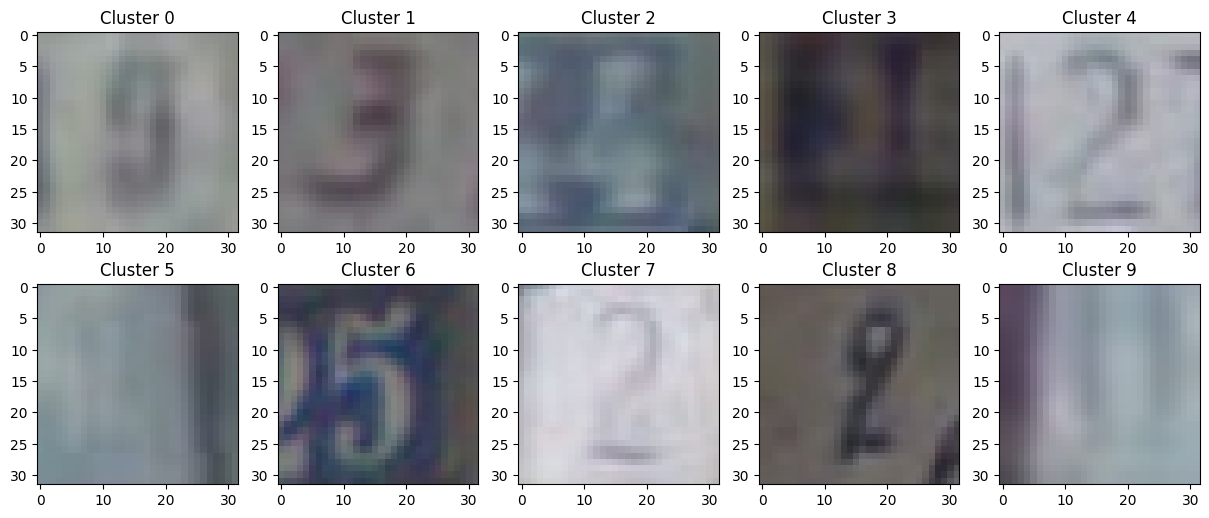

In [110]:

closest_image_idx_27, _  = pairwise_distances_argmin_min(centroids_pca_27,X_train_pca_projected_27)

# Visualize the centroids
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
j=0
for i, ax in enumerate(axes.flat):
    nearest_image = X_train_standardized[closest_image_idx_27[j]].reshape((32, 32, 3))  # Fix the index
    j += 1
    ax.imshow(nearest_image.astype(np.uint8))
    ax.set_title(f"Cluster {i}")
    

plt.show()

In [111]:
from collections import defaultdict


def find_mixed_classes(labels, true_labels):
    cluster_info = defaultdict(list)

    for i in range(len(labels)):
        cluster_info[labels[i]].append(true_labels[i])

    mixed_clusters = []

    for cluster, classes in cluster_info.items():
        unique_classes = set(classes)
        if len(unique_classes) > 1:
            mixed_clusters.append(cluster)

    return mixed_clusters

# Assuming y_train is a dictionary loaded using loadmat


# # Raw data clustering
# kmeans_raw = KMeans(n_clusters=10, n_init=10, random_state=42)
# kmeans_raw.fit(X_train_standardized)
# labels_raw = kmeans_raw.labels_

y_train_labels_raw = kmeans_raw.predict(X_train_raw_flattened)
mixed_clusters_raw = find_mixed_classes(labels_raw, subset_classes_Y_train.T[0])
print("Mixed clusters for raw data:", mixed_clusters_raw)

# For PCA  part (1)a
y_train_labels_pca_27 = kmeans_pca_27.predict(X_train_pca_projected_27)
mixed_clusters_pca_27 = find_mixed_classes(labels_raw, subset_classes_Y_train.T[0])
print("Mixed clusters for PCA part 1(a) data:", mixed_clusters_pca_27)

y_train_labels_pca_10 = kmeans_pca_10.predict(X_train_pca_projected_10)
mixed_clusters_pca_10 = find_mixed_classes(labels_raw, subset_classes_Y_train.T[0])
print("Mixed clusters for PCA part 1(b) data:", mixed_clusters_pca_10)


Mixed clusters for raw data: [8, 9, 0, 2, 7, 1, 5, 4, 3, 6]
Mixed clusters for PCA part 1(a) data: [8, 9, 0, 2, 7, 1, 5, 4, 3, 6]
Mixed clusters for PCA part 1(b) data: [8, 9, 0, 2, 7, 1, 5, 4, 3, 6]


<h2>Observations:</h2>

<p>All clusters exhibit mixed classes, meaning that no cluster exclusively contains images from the same class.</p>

<h2>Part b:</h2>

<ul>
    <li>Code has been implemented to calculate the sum squared error for all clusters obtained from K-Means clustering on the dataset.</li>
    <li>The "Sum Squared Error" has been individually calculated for each cluster.</li>
    <li>Cumulative sum squared error has been computed for all three sets of clustered data.</li>
    <li>Purity metric for each of the three clustered datasets has been determined by forming a contingency matrix.</li>
    <li>The "Rand Index" metric for all three sets of clustered data has been calculated using the <code>rand_score</code> inbuilt function.</li>
</ul>

In [112]:
def calculate_sse_per_cluster(centroids, data, labels):
    sse_per_cluster = defaultdict(float)

    unique_labels = np.unique(labels)

    for cluster_label in unique_labels:
        indices = np.where(labels==cluster_label)[0]
        cluster_points=data[indices]
        # cluster_points = data[labels ]
        centroid = centroids[cluster_label]
        
        sse_per_cluster[cluster_label] = np.sum(np.sum((cluster_points - centroid.reshape(1, -1)) ** 2, axis=1))

    return sse_per_cluster

# ... (rest of your code)

# Calculate SSE for raw data
sse_raw = calculate_sse_per_cluster(centroids_raw, X_train_standardized, labels_raw)
print("SSE per cluster for raw data:")
for cluster_label, sse in sse_raw.items():
    print(f"Cluster {cluster_label}: {sse}")
# print("ab",np.sum(sse_raw[1]))
# print("cd",kmeans_raw.inertia_)
# Calculate SSE for PCA part 1(a) data
sse_pca_27 = calculate_sse_per_cluster(centroids_pca_27, X_train_pca_projected_27, labels_pca_27)
print("SSE per cluster for PCA part 1(a) data:")
for cluster_label, sse in sse_pca_27.items():
    print(f"Cluster {cluster_label}: {sse}")

sse_pca_10 = calculate_sse_per_cluster(centroids_pca_10, X_train_pca_projected_10, labels_pca_10)
print("SSE per cluster for PCA part 1(b) data:")
for cluster_label, sse in sse_pca_10.items():
    print(f"Cluster {cluster_label}: {sse}")

SSE per cluster for raw data:
Cluster 0: 8326481348.474169
Cluster 1: 5531837283.42165
Cluster 2: 10653007187.675726
Cluster 3: 5462257652.357761
Cluster 4: 8845640429.969162
Cluster 5: 11146217305.25378
Cluster 6: 6058149418.237782
Cluster 7: 4243690245.1215415
Cluster 8: 9498097096.485865
Cluster 9: 10123505582.823256
SSE per cluster for PCA part 1(a) data:
Cluster 0: 7957624716.442062
Cluster 1: 7718874636.117781
Cluster 2: 6928732985.383125
Cluster 3: 4764557649.464977
Cluster 4: 8249459895.952852
Cluster 5: 4456823209.429506
Cluster 6: 6605936792.879421
Cluster 7: 4097151950.1263943
Cluster 8: 6826740094.736681
Cluster 9: 3288654550.6534624
SSE per cluster for PCA part 1(b) data:
Cluster 0: 3712622644.9056334
Cluster 1: 2808554792.340843
Cluster 2: 5204623594.590614
Cluster 3: 2973403203.646224
Cluster 4: 4706581373.843563
Cluster 5: 5195544174.403267
Cluster 6: 5657582594.238602
Cluster 7: 5739578063.720117
Cluster 8: 5977641870.640227
Cluster 9: 3210299674.7233667


In [113]:
from sklearn.metrics import rand_score
from sklearn.metrics.cluster import contingency_matrix

def evaluate_clustering_performance(true_labels, predicted_labels):
    """
    Evaluate clustering performance using Rand Index and Purity.

    Parameters:
    - true_labels: Array of true class labels.
    - predicted_labels: Array of predicted cluster labels.

    Returns:
    - rand_index: Rand Index value.
    - purity: Purity value.
    """
    # Calculate Rand Index
    rand_index = rand_score(true_labels, predicted_labels)

    # Calculate Purity
    conf_matrix = contingency_matrix(true_labels, predicted_labels)
    purity = np.sum(np.amax(conf_matrix, axis=0)) / np.sum(conf_matrix)

    return rand_index, purity

print(labels_raw.shape)
rand_index_raw, purity_raw = evaluate_clustering_performance(subset_classes_Y_train.T[0], labels_raw)
rand_index_pca_27, purity_pca_27 = evaluate_clustering_performance(subset_classes_Y_train.T[0], labels_pca_27)
rand_index_pca_10, purity_pca_10 = evaluate_clustering_performance(subset_classes_Y_train.T[0], labels_pca_10)
print("Rand Index for raw data:", rand_index_raw)
print("Purity for raw data:", purity_raw)
print("Rand Index for 27 data:", rand_index_pca_27)
print("Purity for 27 data:", purity_pca_27)
print("Rand Index for 10 data:", rand_index_pca_10)
print("Purity for 10 data:", purity_pca_10)



(25000,)
Rand Index for raw data: 0.8082713740549622
Purity for raw data: 0.11536
Rand Index for 27 data: 0.8082098707948318
Purity for 27 data: 0.11524
Rand Index for 10 data: 0.8082738541541662
Purity for 10 data: 0.11532


<h2>Observations:</h2>

<ul>
    <li>The K-Means clustering conducted above resulted in lower purity, suggesting that the clusters are less homogeneous concerning class labels.</li>
    <li>However, the same clustering produced a high rand-index, indicating a substantial similarity between the predicted clustering and the true clustering.</li>
</ul>

<h2>Part c:</h2>

<ul>
    <li>The code includes functions to assign class labels to clusters.</li>
    <li>Using this unsupervised method, accuracy for test data is calculated.</li>
</ul>

In [114]:
from sklearn.metrics import accuracy_score

def assign_most_frequent_label(cluster_labels, true_labels):
    unique_clusters = np.unique(cluster_labels)
    assigned_labels = [0,0,0,0,0,0,0,0,0,0]
    
    for cluster in unique_clusters:
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_true_labels = true_labels[cluster_indices]
        most_frequent_label = np.bincount(cluster_true_labels).argmax()
        # assigned_labels.extend([most_frequent_label] * len(cluster_indices))
        assigned_labels[cluster]=most_frequent_label
    
    return np.array(assigned_labels)
# print(subset_classes_Y_train.T[0].shape)
# Assign most frequent labels for raw data clustering
predicted_labels_raw = assign_most_frequent_label(labels_raw, subset_classes_Y_train.T[0])

# Assign most frequent labels for PCA part 1(a) data clustering
predicted_labels_pca_27 = assign_most_frequent_label(labels_pca_27, subset_classes_Y_train.T[0])

# Assign most frequent labels for PCA part 1(b) data clustering
predicted_labels_pca_10 = assign_most_frequent_label(labels_pca_10, subset_classes_Y_train.T[0])
test_data=loadmat('./test_32x32.mat')
X_test=test_data['X'].reshape((32*32*3,-1))
X_test_data=X_test.T
test_labels=test_data['y']
x_test_pca=pca.transform(X_test_data)
x_test_pca_27=x_test_pca[:,:27]
x_test_pca_10=x_test_pca[:,:10]
y_kmeans_test_raw=kmeans_raw.predict(X_test_data)
y_kmeans_test_pca_27=kmeans_pca_27.predict(x_test_pca_27)
y_kmeans_test_pca_10=kmeans_pca_10.predict(x_test_pca_10)

def evaluate_clustering_accuracy(y_kmeans_test, classlabel_to_cluster_map, true_labels):
    count_accuracy = 0
    for i in range(len(y_kmeans_test)):
        predicted_test_class_label = classlabel_to_cluster_map[y_kmeans_test[i]]
        if predicted_test_class_label == true_labels[i]:
            count_accuracy += 1
    accuracy = count_accuracy / len(y_kmeans_test)
    return accuracy

# Assuming y_test is a dictionary loaded using loadmat
y_test_labels =test_labels.T[0]

# Assign most frequent labels for test data clustering
predicted_labels_test = assign_most_frequent_label(labels_raw, subset_classes_Y_train.T[0])
# Evaluate clustering accuracy for raw data
accuracy_raw = evaluate_clustering_accuracy(y_kmeans_test_raw,predicted_labels_raw,y_test_labels)
print("Clustering Accuracy for Raw Data:", accuracy_raw)



predicted_labels_test = assign_most_frequent_label(labels_pca_27, subset_classes_Y_train.T[0])
# Evaluate clustering accuracy for raw data
accuracy_pca_27 = evaluate_clustering_accuracy(y_kmeans_test_pca_27,predicted_labels_pca_27,y_test_labels)
print("Clustering Accuracy for 27 Data:", accuracy_pca_27)

predicted_labels_test = assign_most_frequent_label(labels_pca_10, subset_classes_Y_train.T[0])
# Evaluate clustering accuracy for raw data
accuracy_pca_10 = evaluate_clustering_accuracy(y_kmeans_test_pca_10,predicted_labels_pca_10,y_test_labels)
print("Clustering Accuracy for 10 Data:", accuracy_pca_10)
# print(predicted_labels_raw.shape)

# # Calculate accuracy
# accuracy_raw = accuracy_score(y_kmeans_test_raw, predicted_labels_raw)
# accuracy_pca_27 = accuracy_score(y_train_labels, predicted_labels_pca_27)
# accuracy_pca_10 = accuracy_score(y_train_labels, predicted_labels_pca_10)

# print("Accuracy for raw data clustering:", accuracy_raw)
# print("Accuracy for PCA part 1(a) data clustering:", accuracy_pca_27)
# print("Accuracy for PCA part 1(b) data clustering:", accuracy_pca_10)

Clustering Accuracy for Raw Data: 0.11597264904732636
Clustering Accuracy for 27 Data: 0.10333435771358328
Clustering Accuracy for 10 Data: 0.1181238475722188


<h2>Observations:</h2>

<ul>
    <li>The accuracy for K-Means clustering is observed to be less than that for K-NN.</li>
    <li>Consequently, K-NN demonstrates superior performance when compared to K-Means.</li>
</ul>


<h2>Part d:</h2>

<ul>
    <li>Executed K-Means clustering with 5 clusters on data post-PCA with dimensions outlined in 1(A).</li>
    <li>Computed the "Sum Squared Error" for each cluster and the "Cumulative Sum Squared Error."</li>
    <li>Identified and printed various types of classes present in each cluster.</li>
</ul>

In [115]:

X_train_pca_projected_27=X_train_pca[:,:27]
kmeans_pca_27_partd = KMeans(n_clusters=5,n_init=10, random_state=42)
kmeans_pca_27_partd.fit(X_train_pca_projected_27)

# Get cluster labels and centroids
labels_pca_27_partd = kmeans_pca_27_partd.labels_

# print(np.unique(labels_pca_27_partd))
centroids_pca_27_partd = kmeans_pca_27_partd.cluster_centers_
sse_pca_27 = calculate_sse_per_cluster(centroids_pca_27_partd, X_train_pca_projected_27, labels_pca_27_partd)
print("SSE per cluster for PCA part 1(a) data:")
for cluster_label, sse in sse_pca_27.items():
    print(f"Cluster {cluster_label}: {sse}")

mixed_clusters_pca_27_partd = find_mixed_classes(labels_pca_27_partd, y_train_labels_pca_27)
print("cluster label with mixed classes:", mixed_clusters_pca_27_partd)
# print(np.where(labels_pca_27_partd==mixed_clusters_pca_27_partd))
for i in mixed_clusters_pca_27_partd: 
    a=np.unique(subset_classes_Y_train.T[0][np.where(labels_pca_27_partd==i)[0]])
    print(a)

SSE per cluster for PCA part 1(a) data:
Cluster 0: 17964660387.78267
Cluster 1: 16227335581.862698
Cluster 2: 8359359114.737873
Cluster 3: 9849522566.032444
Cluster 4: 18302680839.016586
cluster label with mixed classes: [0, 4, 1, 2, 3]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]


<h2>Observations:</h2>

<p>All clusters display mixed classes, indicating that none of the clusters exclusively contain images from the same class.</p>